In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-earthquake-dataset-stead/merge.hdf5
/kaggle/input/stanford-earthquake-dataset-stead/merge.csv


Para trabajar con el dataset, utilizamos los servicios de kaggle que nos permiten guardar el input de manera persistente, lo cual es conveniente al ser un dataset de ~90GB.

In [2]:
import os
import pandas as pd

input_dir = '/kaggle/input/stanford-earthquake-dataset-stead/'
filename = 'merge.csv'
df_original = pd.read_csv(os.path.join(input_dir, filename), low_memory=False)
df_original.head()

,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-21 05:55:00,noise,109C.TA_201510210555_NO
1,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06 14:50:00,noise,109C.TA_201511061450_NO
2,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-07 02:20:00,noise,109C.TA_201511070220_NO
3,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-14 05:15:00,noise,109C.TA_201511140515_NO
4,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-25 18:50:00,noise,109C.TA_201512251850_NO


Realizamos una copia del dataset, para ejecutar desde este punto las celdas, y no tener que volver a leer el dataset a pandas

In [3]:
df = df_original.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265657 entries, 0 to 1265656
Data columns (total 35 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   network_code                      1265613 non-null  object 
 1   receiver_code                     1265657 non-null  object 
 2   receiver_type                     1265657 non-null  object 
 3   receiver_latitude                 1265657 non-null  float64
 4   receiver_longitude                1265657 non-null  float64
 5   receiver_elevation_m              1265657 non-null  float64
 6   p_arrival_sample                  1030231 non-null  float64
 7   p_status                          1030231 non-null  object 
 8   p_weight                          1030057 non-null  float64
 9   p_travel_sec                      1030231 non-null  float64
 10  s_arrival_sample                  1030231 non-null  float64
 11  s_status                          103

Se trata de un dataset con 1265657 filas y 35 columnas.

La variable trace_name es un identificador único para cada observación:

In [4]:
len(df['trace_name'].unique()) == len(df)

True

Por tanto, lo podemos utilizar como índice de fila.

In [5]:
df = df.set_index('trace_name')
df.head()

,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_type,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category
trace_name,,,,,,,,,,,,,,,,,,,,,
109C.TA_201510210555_NO,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-21 05:55:00,noise
109C.TA_201511061450_NO,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06 14:50:00,noise
109C.TA_201511070220_NO,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-07 02:20:00,noise
109C.TA_201511140515_NO,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-14 05:15:00,noise
109C.TA_201512251850_NO,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-25 18:50:00,noise


network_code, receiver_code, trace_start_time y trace_category se especifican en el trace_name  

trace_name = [receiver_code].[network_code]\_[trace_start_time]\_[trace_category]

Observaciones:
- trace_start_time se expresa como unión sin espacios de las unidades de tiempo
- trace_category toma valores NO y EV para categorías noise y earthquake_local respectivamente

Se convierten a formato fecha las variables source_origin_time y trace_start_time

In [6]:
df['trace_start_time'] = pd.to_datetime(df['trace_start_time'], format='ISO8601')# format="%Y-%m-%d %H:%M:%S")
df['source_origin_time'] = pd.to_datetime(df['source_origin_time'], format='ISO8601')

In [7]:
df.iloc[0]['trace_start_time']

Timestamp('2015-10-21 05:55:00')

Se han recogido dos tipos de señales:  
- noise: sonidos no debidos a terremotos
- earthquake_local: terremotos que se encuentran en un radio menor a 350km

In [8]:
df.loc[:, 'trace_category'].unique()

array(['noise', 'earthquake_local'], dtype=object)

Para estudios que vamos a realizar, vamos dividir en dataframes uno por cada tipo de señal:

### Señales noise

Obtenemos un subdataset cuyas observaciones son señales noise, y podemos ver el ratio y el tamaño del subconjunto

In [9]:
df_noise = df.loc[df.loc[:, 'trace_category'] == 'noise']
size = len(df_noise)
print(f'len(df_noise)={size}, ratio={size/len(df)*100:.2f}%')
df_noise.head()

len(df_noise)=235426, ratio=18.60%


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_type,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category
trace_name,,,,,,,,,,,,,,,,,,,,,
109C.TA_201510210555_NO,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-21 05:55:00,noise
109C.TA_201511061450_NO,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06 14:50:00,noise
109C.TA_201511070220_NO,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-07 02:20:00,noise
109C.TA_201511140515_NO,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-14 05:15:00,noise
109C.TA_201512251850_NO,TA,109C,HH,32.8889,-117.1051,150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-25 18:50:00,noise


En la documentación del dataset se muestra que las señales categorizadas como noise, solo cuentan con 8 variables y el resto toman valores NA, eliminamos las variables que tienen todos sus valores NA:

In [10]:
df_noise = df_noise.dropna(axis=1, how='all')
print(df_noise.shape)
df_noise.head()

(235426, 8)


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,trace_start_time,trace_category
trace_name,,,,,,,,
109C.TA_201510210555_NO,TA,109C,HH,32.8889,-117.1051,150.0,2015-10-21 05:55:00,noise
109C.TA_201511061450_NO,TA,109C,HH,32.8889,-117.1051,150.0,2015-11-06 14:50:00,noise
109C.TA_201511070220_NO,TA,109C,HH,32.8889,-117.1051,150.0,2015-11-07 02:20:00,noise
109C.TA_201511140515_NO,TA,109C,HH,32.8889,-117.1051,150.0,2015-11-14 05:15:00,noise
109C.TA_201512251850_NO,TA,109C,HH,32.8889,-117.1051,150.0,2015-12-25 18:50:00,noise


Una vez hecho esto, podemos comprobar si existen más valores NA, debidos a incosistencias.

In [11]:
print(f'Número total de NA en el dataframe: {(col_na:=df_noise.isna().sum()).sum()}')
df_noise_na = pd.DataFrame({'Valores NA': col_na})
df_noise_na

Número total de NA en el dataframe: 0


,Valores NA
network_code,0
receiver_code,0
receiver_type,0
receiver_latitude,0
receiver_longitude,0
receiver_elevation_m,0
trace_start_time,0
trace_category,0


Realizamos comprobaciones similares para los datos de terremotos.

### Señales noise

In [19]:
df_earthquakes = df.loc[df.loc[:, 'trace_category'] == 'earthquake_local']
size = len(df_earthquakes)
print(f'len(df_earthquakes)={size}, ratio={size/len(df)*100:.2f}%')
df_earthquakes.head()

len(df_earthquakes)=1030231, ratio=81.40%


,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_type,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category
trace_name,,,,,,,,,,,,,,,,,,,,,
109C.TA_20060723155859_EV,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.5,17.080000,...,ml,NaN,NaN,0.92,102.09,159.3,[56.79999924 55.40000153 47.40000153],[[2896.]],2006-07-23 15:59:00.960,earthquake_local
109C.TA_20061103155652_EV,TA,109C,BH,32.8889,-117.1051,150.0,600.0,manual,0.5,16.879999,...,mb,NaN,NaN,0.91,101.34,281.7,[65. 65.5 61.40000153],[[5508.]],2006-11-03 15:56:53.610,earthquake_local
109C.TA_20061103161223_EV,TA,109C,BH,32.8889,-117.1051,150.0,500.0,manual,0.5,17.260000,...,ml,NaN,NaN,0.92,101.87,280.5,[37.20000076 42. 38.59999847],[[3114.]],2006-11-03 16:12:24.700,earthquake_local
109C.TA_20061114133221_EV,TA,109C,BH,32.8889,-117.1051,150.0,900.0,manual,0.5,17.280001,...,ml,NaN,NaN,0.93,103.26,281.6,[54.09999847 54.90000153 45.5 ],[[3152.]],2006-11-14 13:32:22.540,earthquake_local
109C.TA_20061127104640_EV,TA,109C,BH,32.8889,-117.1051,150.0,700.0,manual,0.5,18.139999,...,ml,NaN,NaN,0.92,102.48,4.7,[58.20000076 56.20000076 53.79999924],[[3134.]],2006-11-27 10:46:41.060,earthquake_local


In [20]:
print(f'Número total de NA en el dataframe: {(col_na:=df_earthquakes.isna().sum()).sum()}')
df_earthquakes_na = pd.DataFrame({'Valores NA': col_na})
df_earthquakes_na.loc[df_earthquakes_na.loc[:, 'Valores NA'] != 0, :] # Mostramos solo los que no tienen 0

Número total de NA en el dataframe: 5165058


,Valores NA
network_code,44
p_weight,174
s_weight,155
source_origin_uncertainty_sec,889937
source_error_sec,570728
source_gap_deg,649414
source_horizontal_uncertainty_km,589493
source_depth_km,49
source_depth_uncertainty_km,660808
source_magnitude_author,780053


Se eliminan las observaciones con valores NA en las variables network_code, p_weight, s_weight, source_depth_km, por tener una muy baja representación sobre el dataset

In [22]:
df_earthquakes = df_earthquakes.dropna(axis=0, subset=['network_code', 'p_weight', 's_weight', 'source_depth_km'])
print(f'Número total de NA en el dataframe: {(col_na:=df_earthquakes.isna().sum()).sum()}')
df_earthquakes_na = pd.DataFrame({'Valores NA': col_na})
df_earthquakes_na.loc[df_earthquakes_na.loc[:, 'Valores NA'] != 0, :] # Mostramos solo los que no tienen 0

Número total de NA en el dataframe: 5163339


,Valores NA
source_origin_uncertainty_sec,889692
source_error_sec,570574
source_gap_deg,649260
source_horizontal_uncertainty_km,589333
source_depth_uncertainty_km,660667
source_magnitude_author,779873
source_mechanism_strike_dip_rake,1023940


Podemos comprobar mediante source_id como se distribuyen el número de muestras que hacen referencia al mismo terremoto

In [23]:
earthquake_samples = df_earthquakes.groupby('source_id')
sizes = earthquake_samples.size()
sizes.describe()

count    441642.000000
mean          2.332122
std           2.380657
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          90.000000
dtype: float64

<Axes: xlabel='source_magnitude_type'>

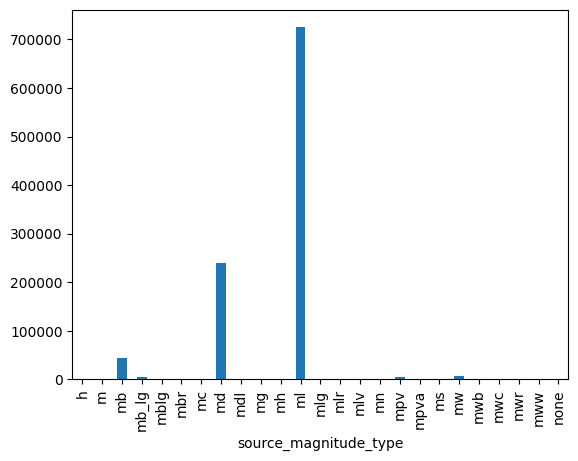

In [25]:
df_earthquakes.groupby('source_magnitude_type').size().plot(kind='bar')

<Axes: xlabel='source_magnitude_type'>

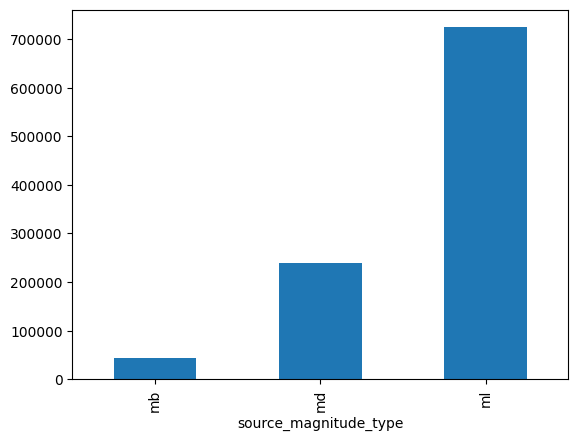

In [26]:
used_scales = ['mb', 'md', 'ml']
df_earthquakes = df_earthquakes[df_earthquakes['source_magnitude_type'].isin(used_scales)]
df_earthquakes.groupby('source_magnitude_type').size().plot(kind='bar')

<Axes: xlabel='source_magnitude'>

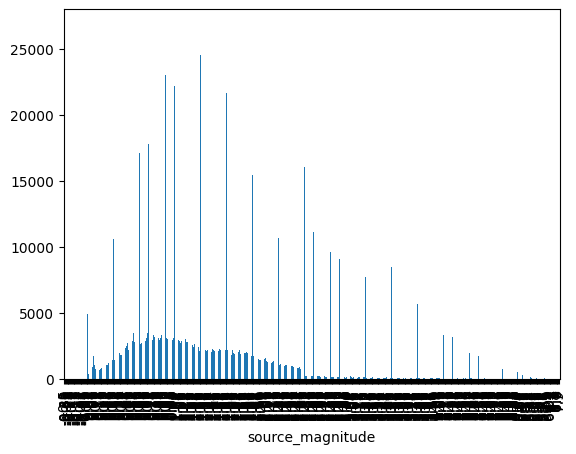

In [17]:
df_earthquakes.groupby('source_magnitude').size().plot(kind='bar')